# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into the [`deepracer-utils` library](https://github.com/aws-deepracer-community/deepracer-utils).

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:
* AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html
* Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

* AWS DeepRacer Team for initial workbooks created for DeepRacer Workshops at Summits and re:Invent.
* [CodeLikeAMother](https://codelikeamother.uk) for initial rework of the notebook.
* [The AWS DeepRacer Community](http://join.deepracing.io) for feedback and incremental improvements.

# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
# Make sure you have the required pre-reqs

import sys

!{sys.executable} -m pip install --upgrade -r requirements.txt

## Imports

Run the imports block below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import os

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog, \
    S3FileHandler, FSFileHandler

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [3]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. The simplest way to read in training data is using the sim-trace files.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md).

In [4]:
PREFIX='MarkP-14fSuperHigh-2'   # Name of the model, without trailing '/'
BUCKET='markpett-training'       # Bucket name is default 'bucket' when training locally
PROFILE=None          # The credentials profile in .aws - 'minio' for local training
S3_ENDPOINT_URL=None  # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [5]:
fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
log = DeepRacerLog(filehandler=fh)
log.load_training_trace()

In [6]:
# # Example / Alternative for logs on file-system
# fh = FSFileHandler(model_folder='logs/sample-console-logs', robomaker_log_path='logs/sample-console-logs/logs/training/training-20220611230353-EHNgTNY2T9-77qXhqjBi6A-robomaker.log')
# log = DeepRacerLog(filehandler=fh)
# log.load_robomaker_logs()

In [7]:
try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Logs not available")

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5'}
-------------
{'batch_size': 128,
 'beta_entropy': 0.001,
 'discount_factor': 0.99,
 'e_greedy_value': 0.001,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 2e-05,
 'num_episodes_between_training': 20,
 'num_epochs': 6,
 'stack_size': 1,
 'term_cond_avg_score': 20100.0,
 'term_cond_max_episodes': 50100}
-------------
[{'speed': 0.8, 'steering_angle': -30},
 {'speed': 1.2, 'steering_angle': -30},
 {'speed': 1.5, 'steering_angle': -30},
 {'speed': 0.8, 'steering_angle': -20},
 {'speed': 1.2, 'steering_angle': -20},
 {'speed': 1.5, 'steering_angle': -20},
 {'speed': 2.0, 'steering_angle': -20},
 {'speed': 0.8, 'steering_angle': -10},
 {'speed': 1.2, 'steering_angle': -10},
 {'speed': 1.5, 'steering_angle': -10},
 {'speed': 2.0, 'steering_angle': -10},
 {'speed': 2.5, 'steering_angle': -10},
 {'speed': 3.0, 'steering_angle': -10},
 {

In [8]:
df = log.dataframe()

If the code above worked, you will see a list of details printed above: a bit about the agent and the network, a bit about the hyperparameters and some information about the action space. Now let's see what got loaded into the dataframe - the data structure holding your simulation information. the `head()` method prints out a few first lines of the data:

In [9]:
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
0,0,1.0,-0.518853,-5.401922,-179.947927,-2.0,4.0,44,0.0,False,True,0.219758,1,63.858625,7.924,prepare,0.0,0,0,0
1,0,2.0,-0.518635,-5.401924,-179.947654,4.0,3.5,67,1.0,False,True,0.219417,1,63.858625,8.004,in_progress,0.0,0,0,0
2,0,3.0,-0.542897,-5.400354,179.770851,30.0,0.8,95,1.0,False,True,0.257409,1,63.858625,8.047,in_progress,0.0,0,0,0
3,0,4.0,-0.553399,-5.402525,-179.759677,-8.0,3.5,19,1.0,False,True,0.273856,1,63.858625,8.152,in_progress,0.0,0,0,0
4,0,5.0,-0.610689,-5.411989,-177.678414,6.0,4.0,76,1.0,False,True,0.363584,2,63.858625,8.194,in_progress,0.0,0,0,0


In [10]:
df.shape

(308199, 20)

In [11]:
pd.set_option('display.max_columns', 500)
df.sort_values('reward', ascending=False).head(20)

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
258412,838,253.0,0.560471,5.031125,-1.718742,-4.0,4.0,36,9.109207,False,True,76.439922,142,63.858625,24541.294,in_progress,0.0,41,0,838
79155,254,256.0,-5.757563,-0.157029,171.415661,-10.0,2.5,11,8.837970,False,False,78.482072,104,63.858625,7431.155,in_progress,0.0,12,0,254
159989,519,240.0,1.150480,5.097438,-1.447222,6.0,3.5,75,8.681591,False,True,72.233801,144,63.858625,15126.342,in_progress,0.0,25,0,519
284463,920,227.0,-0.385653,5.194192,11.839989,-8.0,4.0,20,8.489300,False,True,64.756880,139,63.858625,27219.502,in_progress,0.0,46,0,920
32473,104,158.0,0.687342,5.004035,-5.577942,6.0,3.5,75,8.419179,False,True,46.634261,143,63.858625,3055.721,in_progress,0.0,5,0,104
26969,86,284.0,-6.742119,-4.393863,145.564724,-20.0,0.8,3,8.383273,False,True,80.625092,24,63.858625,2518.668,in_progress,0.0,4,0,86
265468,861,213.0,0.582537,5.233575,5.058867,-8.0,2.5,17,8.335926,False,True,61.316485,142,63.858625,25388.760,in_progress,0.0,43,0,861
32909,105,270.0,-6.252353,-4.595944,140.372192,-10.0,1.2,8,8.334393,False,True,85.212395,23,63.858625,3085.091,in_progress,0.0,5,0,105
208254,681,81.0,2.343877,-2.064035,28.927943,10.0,2.5,89,8.263701,False,False,21.783655,58,63.858625,19899.508,in_progress,0.0,34,0,681
159987,519,238.0,0.719504,5.107821,0.768090,-4.0,4.0,36,8.262433,False,True,71.599539,143,63.858625,15126.218,in_progress,0.0,25,0,519


In [12]:
df.sort_values('progress', ascending=False).head(20)

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
204191,667,329.0,1.227154,2.077782,153.839170,20.0,2.0,94,1.593027,True,True,100.0,76,63.858625,19464.926,lap_complete,0.0,33,0,667
308198,999,341.0,2.682296,-5.213135,-177.340189,8.0,3.0,82,2.119146,True,True,100.0,203,63.858625,29331.155,lap_complete,0.0,49,0,999
150730,489,336.0,-3.789509,-0.587189,-170.025528,-2.0,3.5,43,2.886635,True,True,100.0,97,63.858625,14327.731,lap_complete,0.0,24,0,489
186688,609,338.0,-4.103746,-0.512944,-177.427917,-8.0,3.0,18,1.457157,True,True,100.0,98,63.858625,17771.796,lap_complete,0.0,30,0,609
218027,710,325.0,-6.448330,0.235702,131.126865,-10.0,1.2,8,1.130082,True,True,100.0,108,63.858625,20741.607,lap_complete,0.0,35,0,710
305890,992,341.0,-2.826500,3.840696,40.011395,-4.0,4.0,36,3.472499,True,True,100.0,129,63.858625,29176.660,lap_complete,0.0,49,0,992
186350,608,339.0,-1.308520,0.999871,-134.564837,-8.0,3.5,19,0.234748,True,True,100.0,87,63.858625,17749.092,lap_complete,0.0,30,0,608
138730,449,339.0,-3.776533,-0.400855,-162.234679,-2.0,3.5,43,3.078367,True,True,100.0,97,63.858625,13181.279,lap_complete,0.0,22,0,449
1782,5,347.0,1.664478,-2.460362,16.644776,10.0,3.0,90,5.106699,True,True,100.0,55,63.858625,127.626,lap_complete,0.0,0,0,5
69003,222,317.0,-6.294979,-4.597872,136.799155,-8.0,1.2,14,4.055926,True,True,100.0,23,63.858625,6565.671,lap_complete,0.0,11,0,222


## Load waypoints for the track you want to run analysis on

The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [13]:
tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_april_open.npy - I don't know
2022_april_open_ccw.npy - I don't know
2022_april_open_cw.npy - I don't know
2022_april_pro.npy - I don't know
2022_april_pro_ccw.npy - I don't know
2022_april_pro_cw.npy - I don't know
2022_august_open.npy - I don't know
2022_august_open_ccw.npy - I don't know
2022_august_open_cw.npy - I don't know
2022_august_pro.npy - I don't know
2022_august_pro_ccw.npy - I don't know
2022_august_pro_cw.npy - I don't know
2022_july_open.npy - I don't know
2022_july_pro.npy - I don't know
2022_july_pro_ccw.npy - I don't know
2022_july_pro_cw.npy - I don't know
2022_june_open.npy - I don't know
2022_june_open_ccw.npy - I don't know
2022_june_open_cw.npy - I don't know
2022_june_pro.npy - I don't know
2022_june_pro_ccw.npy - I don't know
2022_june_pro_cw.npy - I don't know
2022_march_open.npy - I don't know
2022_march_open_ccw.npy - I don't know
2022_march_open_cw.npy - I don't know
2022_march_pro.npy - I don't know
2022_march_pro_ccw.npy - I don't know
2022_march_pr

Now let's load the track:

Loaded 215 waypoints


<Axes: >

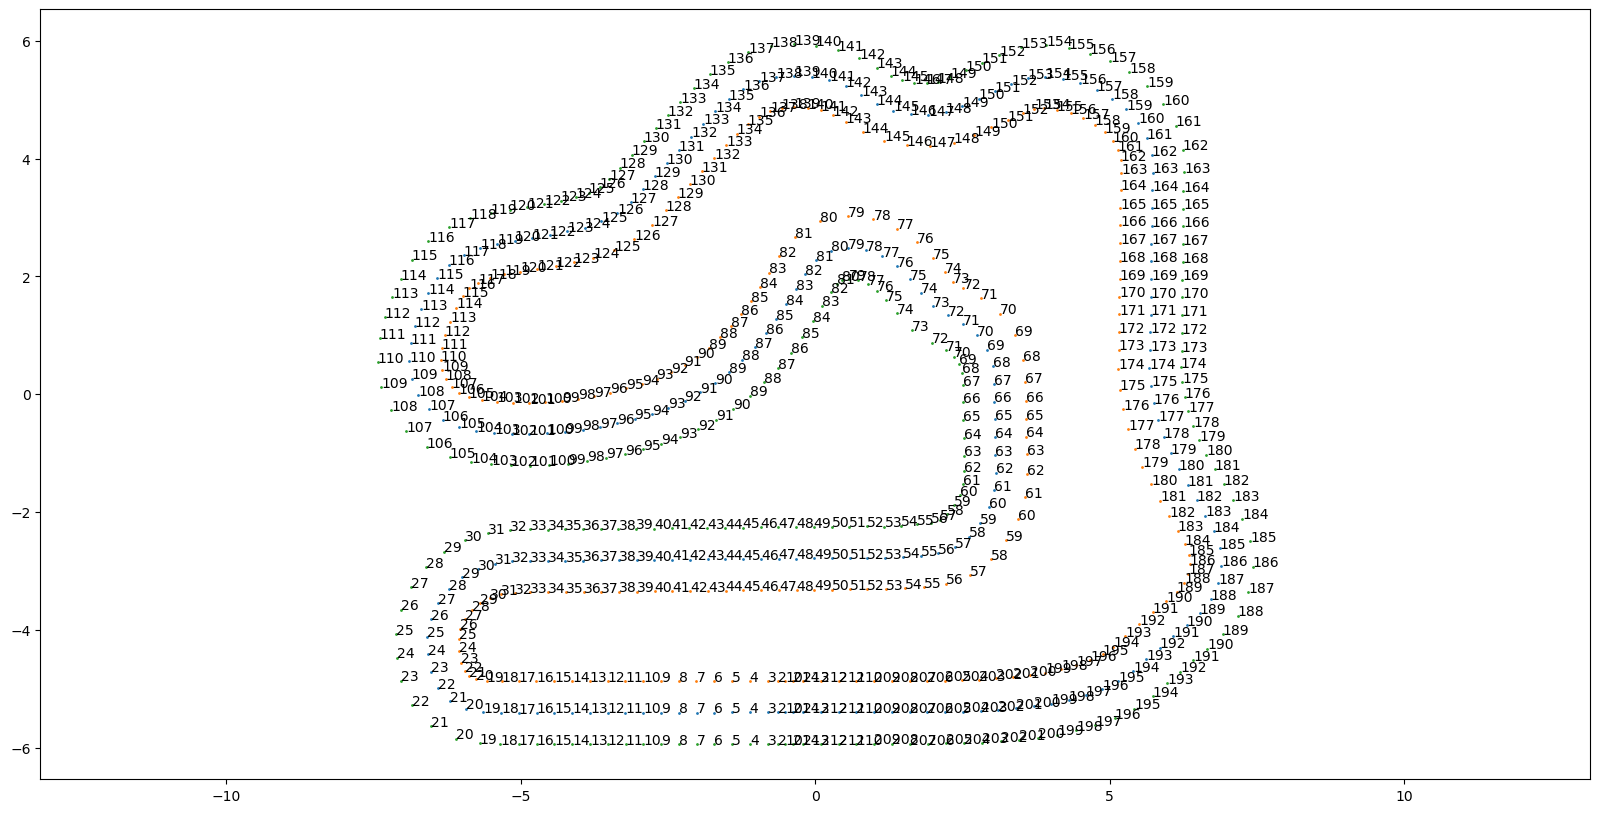

In [14]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    # track_name = "2022_reinvent_champ"
    # track_name = "red_star_pro_cw"
    # track_name = "2022_july_pro_ccw"
    # track_name = "2022_may_open_ccw"
    track_name = "2022_may_pro_cw"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the original notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of dividing amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

new reward not found, using reward as its values
Number of episodes =  999
Number of iterations =  49


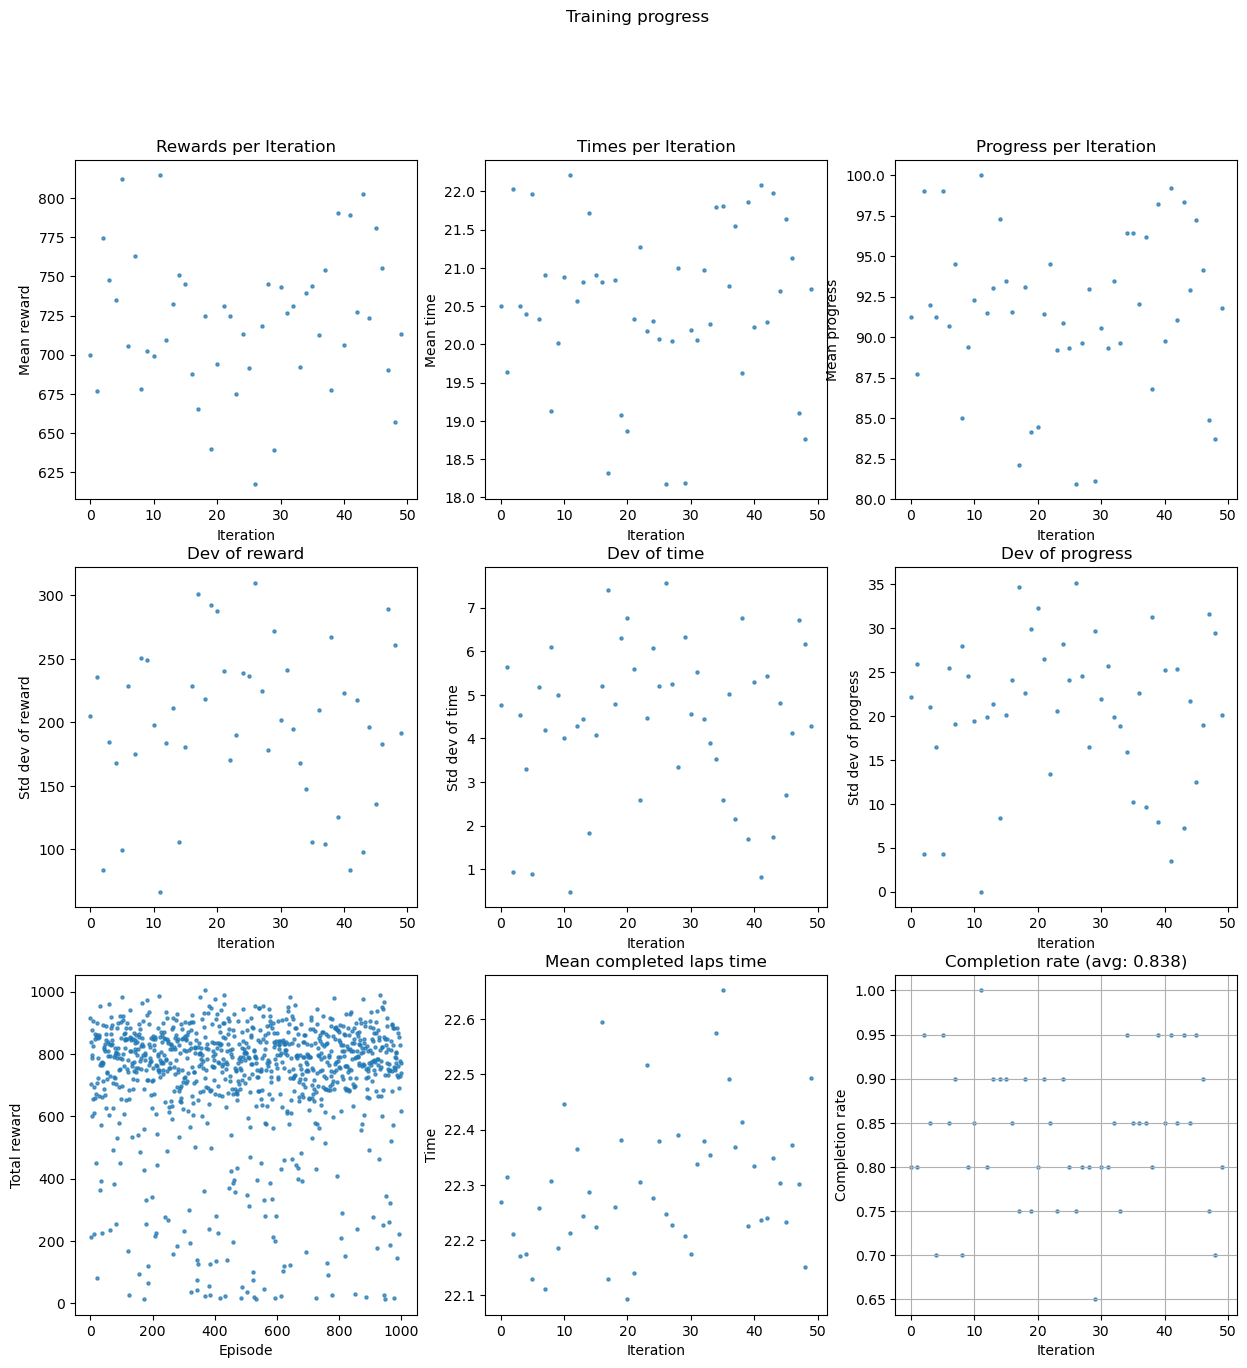

<Figure size 640x480 with 0 Axes>

In [15]:
simulation_agg = au.simulation_agg(df)
try: 
    if df.nunique(axis=0)['worker'] > 1:
        print("Multiple workers have been detected, reloading data with grouping by unique_episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
except:
    print("Multiple workers not detected, assuming 1 worker")

au.analyze_training_progress(simulation_agg, title='Training progress')

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

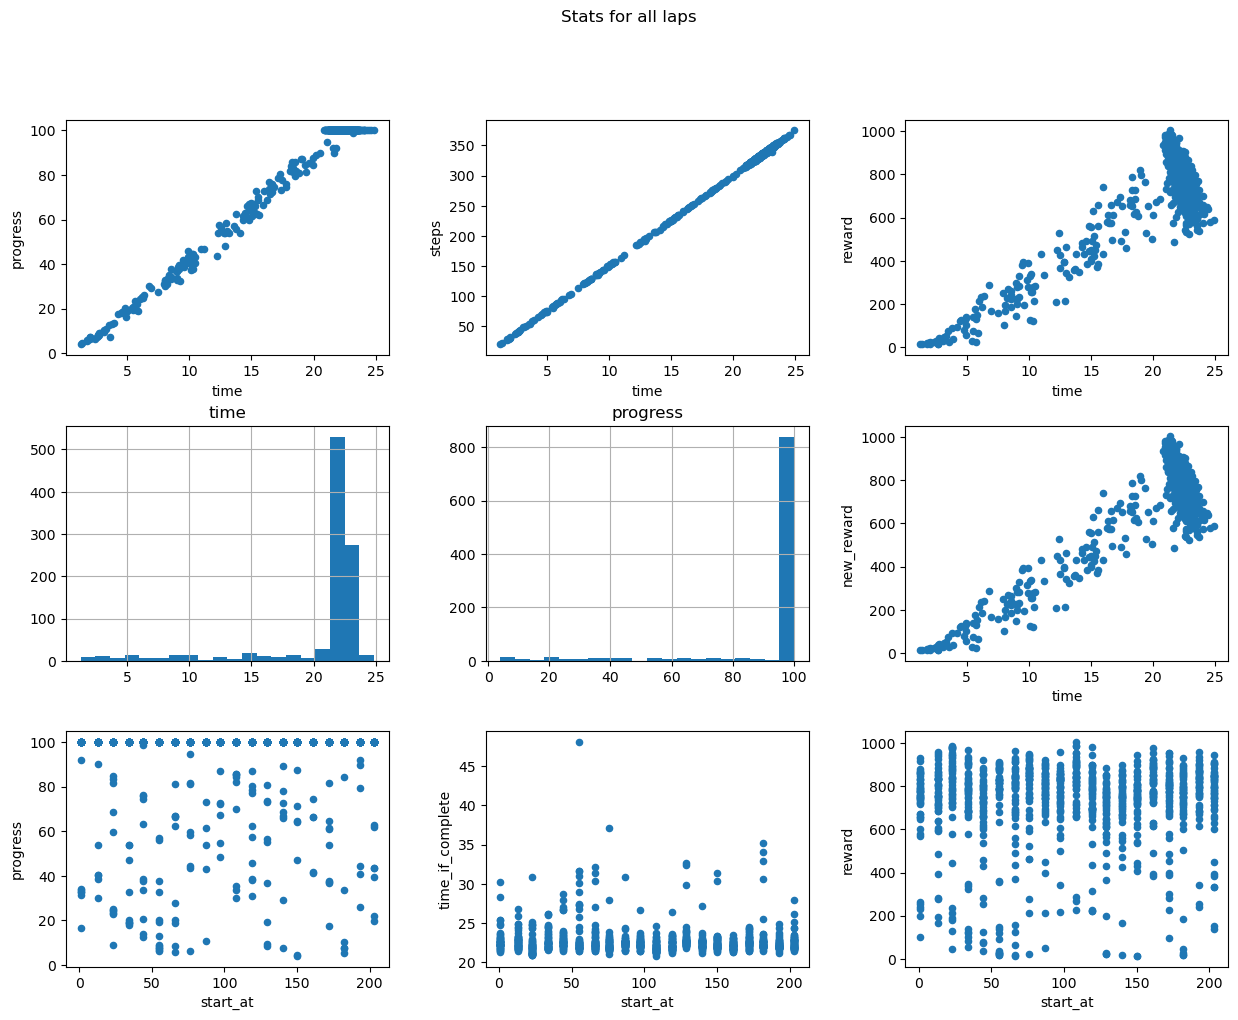

<Figure size 640x480 with 0 Axes>

In [16]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

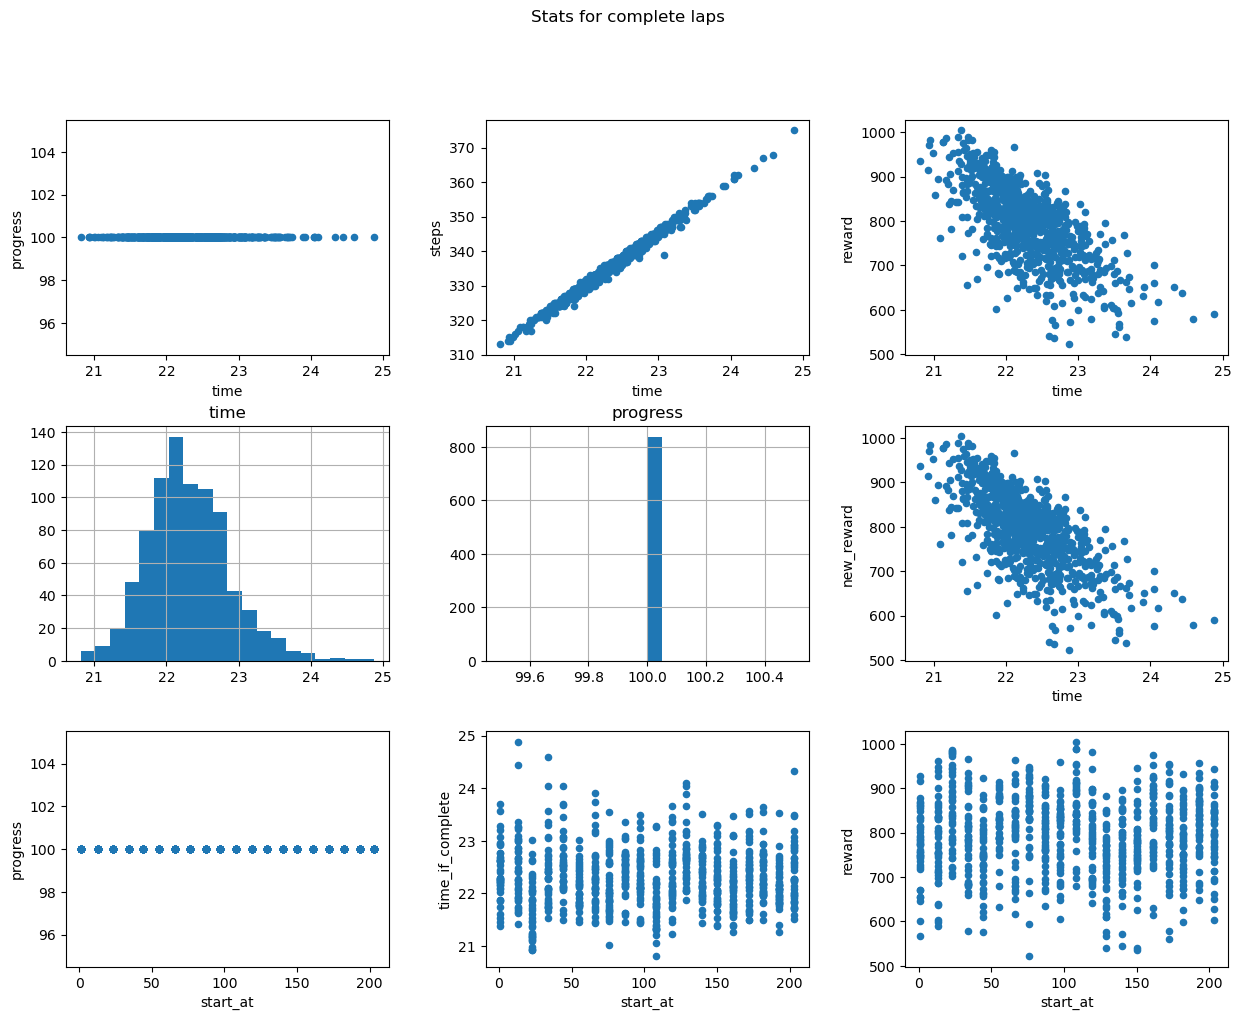

<Figure size 640x480 with 0 Axes>

In [17]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

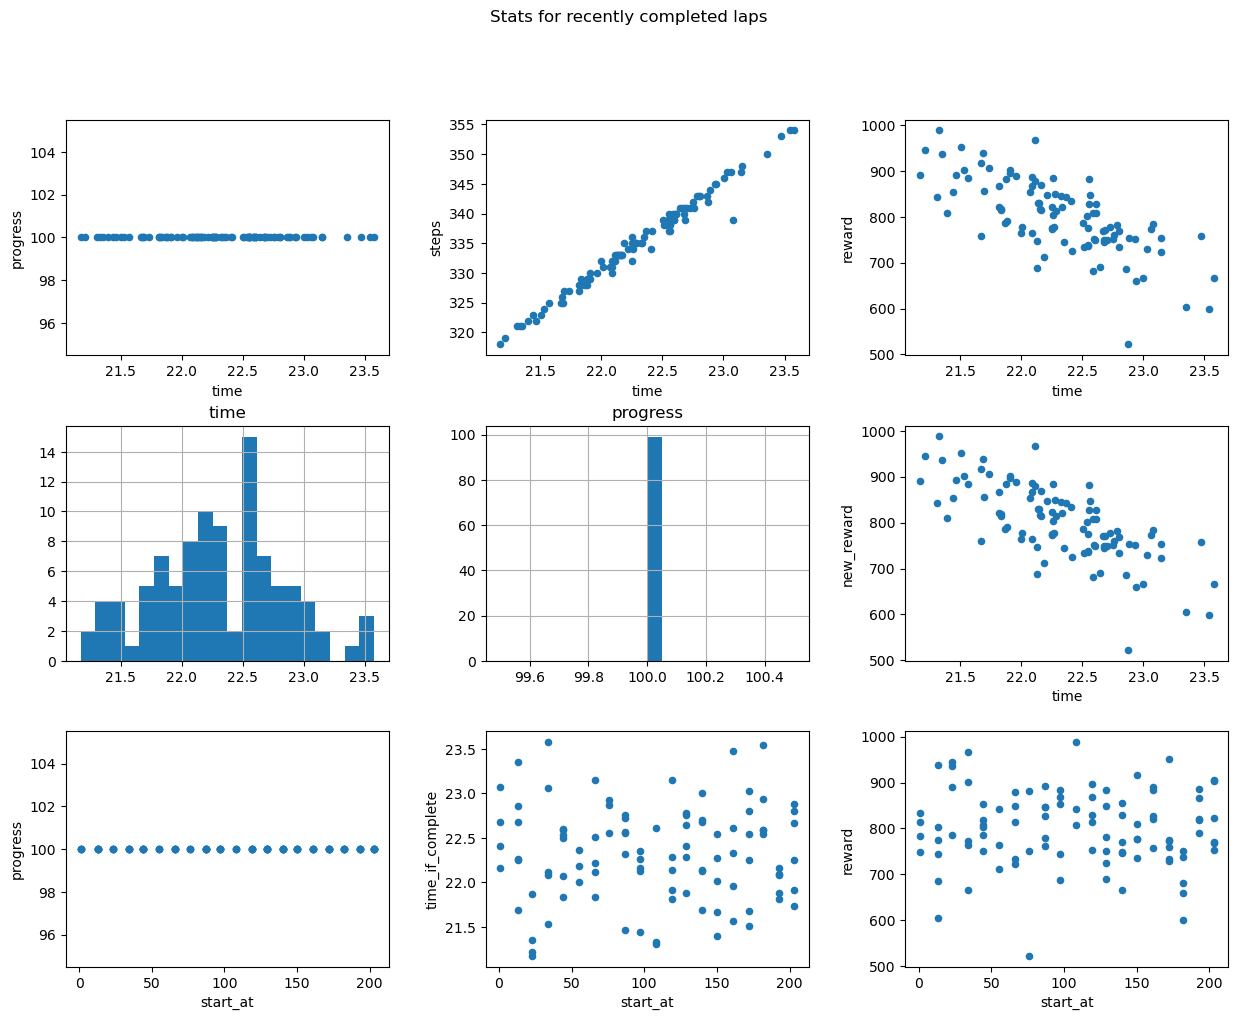

<Figure size 640x480 with 0 Axes>

In [18]:
# Recent laps
latest_iteration = complete_ones['iteration'].max() - 5
recently_completed = complete_ones[complete_ones['iteration'] >= latest_iteration]
if recently_completed.shape[0] > 0:
    au.scatter_aggregates(recently_completed, 'Stats for recently completed laps')
else:
    print('No complete laps yet.')

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

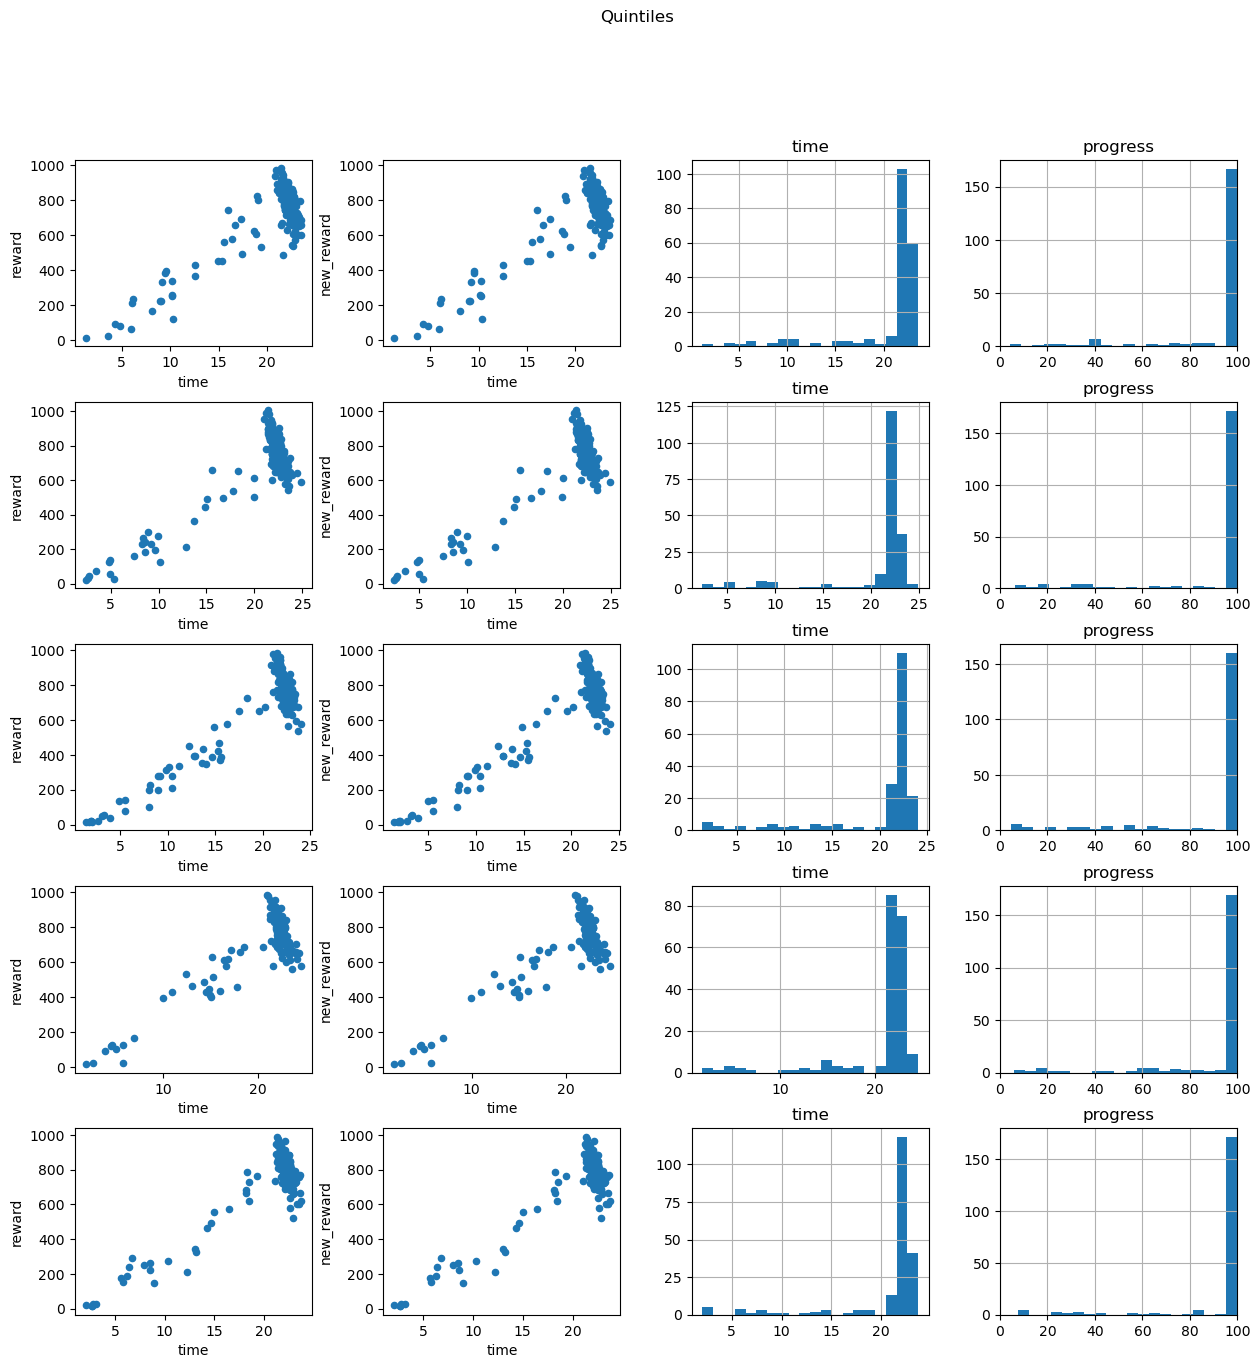

<Figure size 640x480 with 0 Axes>

In [19]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [20]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
370,18,370,322.0,108,100.0,21.380,61.008691,1004.004874,2.880124,1004.004874,21.380,1004.004874,2nd,1
430,21,430,323.0,108,100.0,21.470,60.769496,988.227095,2.835604,988.227095,21.470,988.227095,3rd,1
930,46,930,321.0,108,100.0,21.330,61.003904,988.062319,2.897196,988.062319,21.330,988.062319,5th,1
222,11,222,317.0,23,100.0,21.164,60.365209,986.908496,2.911356,986.908496,21.164,986.908496,2nd,1
642,32,642,314.0,23,100.0,20.947,60.344216,983.402337,2.935350,983.402337,20.947,983.402337,4th,1
102,5,102,322.0,23,100.0,21.475,60.716717,982.577036,2.843168,982.577036,21.475,982.577036,1st,1
351,17,351,323.0,119,100.0,21.523,60.879024,981.448139,2.887926,981.448139,21.523,981.448139,2nd,1
782,39,782,318.0,23,100.0,21.127,60.584839,978.504191,2.927987,978.504191,21.127,978.504191,4th,1
402,20,402,318.0,23,100.0,21.125,60.575292,977.129683,2.923270,977.129683,21.125,977.129683,3rd,1
875,43,875,322.0,161,100.0,21.408,61.301594,975.607001,2.908075,975.607001,21.408,975.607001,5th,1


In [21]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
190,9,190,313.0,108,100.0,20.811,60.620396,936.201080,2.938019,936.201080,20.811,936.201080,1st,1
442,22,442,314.0,23,100.0,20.922,60.305757,915.224273,2.947134,915.224273,20.922,915.224273,3rd,1
182,9,182,315.0,23,100.0,20.931,60.389781,971.850797,2.967302,971.850797,20.931,971.850797,1st,1
642,32,642,314.0,23,100.0,20.947,60.344216,983.402337,2.935350,983.402337,20.947,983.402337,4th,1
382,19,382,315.0,23,100.0,20.991,60.773861,952.562284,2.953333,952.562284,20.991,952.562284,2nd,1


In [22]:
# View five best rewarded completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
370,18,370,322.0,108,100.0,21.380,61.008691,1004.004874,2.880124,1004.004874,21.380,1004.004874,2nd,1
430,21,430,323.0,108,100.0,21.470,60.769496,988.227095,2.835604,988.227095,21.470,988.227095,3rd,1
930,46,930,321.0,108,100.0,21.330,61.003904,988.062319,2.897196,988.062319,21.330,988.062319,5th,1
222,11,222,317.0,23,100.0,21.164,60.365209,986.908496,2.911356,986.908496,21.164,986.908496,2nd,1
642,32,642,314.0,23,100.0,20.947,60.344216,983.402337,2.935350,983.402337,20.947,983.402337,4th,1


In [23]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
370,18,370,322.0,108,100.0,21.380,61.008691,1004.004874,2.880124,1004.004874,21.380,1004.004874,2nd,1
430,21,430,323.0,108,100.0,21.470,60.769496,988.227095,2.835604,988.227095,21.470,988.227095,3rd,1
930,46,930,321.0,108,100.0,21.330,61.003904,988.062319,2.897196,988.062319,21.330,988.062319,5th,1
222,11,222,317.0,23,100.0,21.164,60.365209,986.908496,2.911356,986.908496,21.164,986.908496,2nd,1
642,32,642,314.0,23,100.0,20.947,60.344216,983.402337,2.935350,983.402337,20.947,983.402337,4th,1


In [24]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
0,0,0,324.0,1,100.0,21.619,61.166271,916.291197,2.902778,916.291197,21.619,916.291197,1st,1
1,0,1,349.0,13,100.0,23.258,61.661417,703.918841,2.744986,703.918841,23.258,703.918841,1st,1
3,0,3,325.0,34,100.0,21.716,61.263008,837.287052,2.912000,837.287052,21.716,837.287052,1st,1
5,0,5,347.0,55,100.0,23.025,62.400790,788.785768,2.768300,788.785768,23.025,788.785768,1st,1
6,0,6,340.0,66,100.0,22.605,61.776065,798.118432,2.786471,798.118432,22.605,798.118432,1st,1


In [25]:
# View information for a couple first episodes
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
0,0,0,324.0,1,100.000000,21.619,61.166271,916.291197,2.902778,916.291197,21.619000,916.291197,1st,1
1,0,1,349.0,13,100.000000,23.258,61.661417,703.918841,2.744986,703.918841,23.258000,703.918841,1st,1
2,0,2,91.0,23,24.307230,6.021,14.951555,212.098348,2.605495,212.098348,24.770407,872.573075,1st,0
3,0,3,325.0,34,100.000000,21.716,61.263008,837.287052,2.912000,837.287052,21.716000,837.287052,1st,1
4,0,4,347.0,44,98.706078,23.182,60.712485,599.946649,2.698559,599.946649,23.485889,607.811254,1st,0


In [26]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==10]

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,delta_time,delta_dist,new_reward
3098,10,1.0,-6.746350,0.000687,126.863407,-6.0,3.5,27,0.000000,False,True,0.218944,108,63.858625,216.076,prepare,0.0,0,0,10,0.000,0.000000,0.000000
3099,10,2.0,-6.746175,0.000467,126.838996,-8.0,2.5,17,1.000000,False,True,0.218521,108,63.858625,216.103,in_progress,0.0,0,0,10,0.027,0.000281,1.000000
3100,10,3.0,-6.746979,0.000952,126.946748,-8.0,1.2,14,1.000000,False,True,0.219704,108,63.858625,216.197,in_progress,0.0,0,0,10,0.094,0.000939,1.000000
3101,10,4.0,-6.765385,0.032294,125.931297,-8.0,1.2,14,1.000000,False,True,0.276071,108,63.858625,216.253,in_progress,0.0,0,0,10,0.056,0.036347,1.000000
3102,10,5.0,-6.773891,0.048324,125.306554,-30.0,1.5,2,1.000000,False,True,0.304358,108,63.858625,216.315,in_progress,0.0,0,0,10,0.062,0.018147,1.000000
3103,10,6.0,-6.790852,0.093753,122.361709,-30.0,1.5,2,1.000000,False,True,0.380249,108,63.858625,216.374,in_progress,0.0,0,0,10,0.059,0.048492,1.000000
3104,10,7.0,-6.798206,0.157206,116.007007,-8.0,1.2,14,1.000000,False,True,0.476483,109,63.858625,216.421,in_progress,0.0,0,0,10,0.047,0.063878,1.000000
3105,10,8.0,-6.803759,0.213032,111.405003,-10.0,1.2,8,1.000000,False,True,0.560600,109,63.858625,216.512,in_progress,0.0,0,0,10,0.091,0.056101,1.000000
3106,10,9.0,-6.816490,0.315702,105.837951,-8.0,2.5,17,1.000000,False,True,0.735499,109,63.858625,216.570,in_progress,0.0,0,0,10,0.058,0.103457,1.000000
3107,10,10.0,-6.819334,0.348338,104.233833,-10.0,2.5,11,1.000000,False,True,0.786729,109,63.858625,216.686,in_progress,0.0,0,0,10,0.116,0.032759,1.000000


## Analyze the reward distribution for your reward function

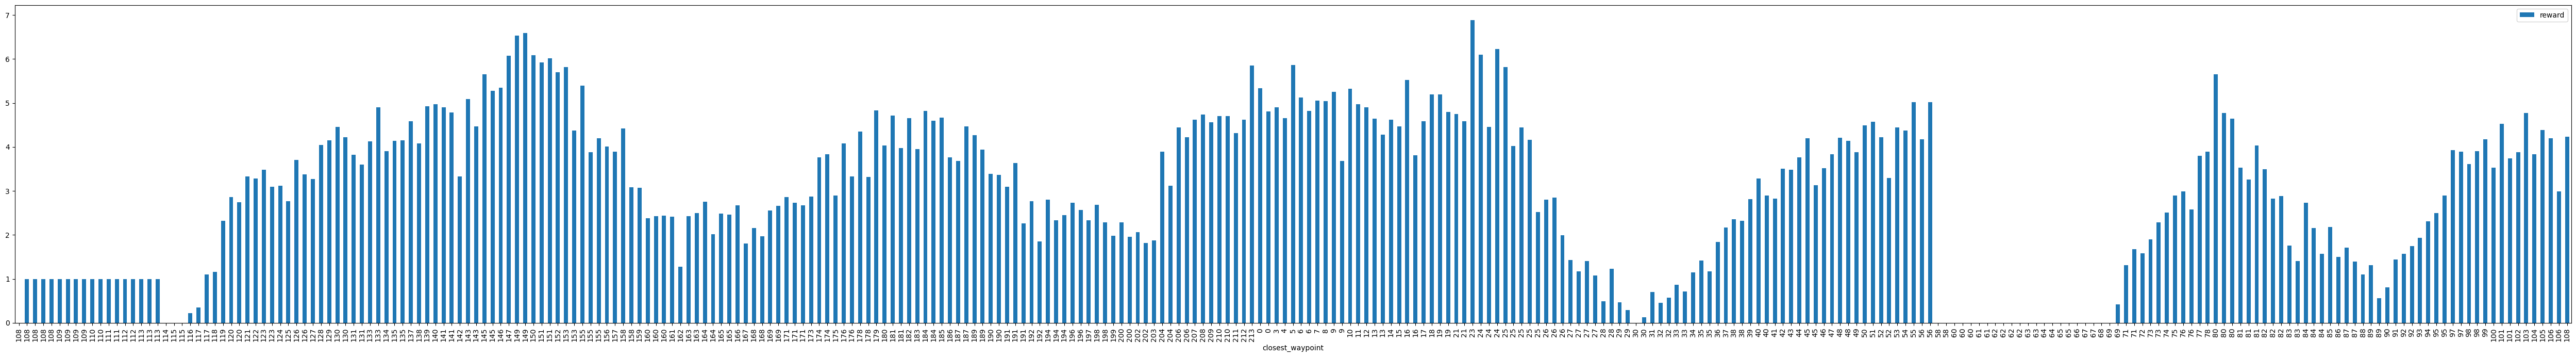

In [27]:
# This shows a histogram of actions per closest waypoint for episode 889.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']==190]
if episode.empty:
    print("You probably don't have episode with this number, try a lower one.")
else:
    episode.plot.bar(x='closest_waypoint', y='reward', figsize=(64, 8))

### Path taken for top reward iterations

NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.

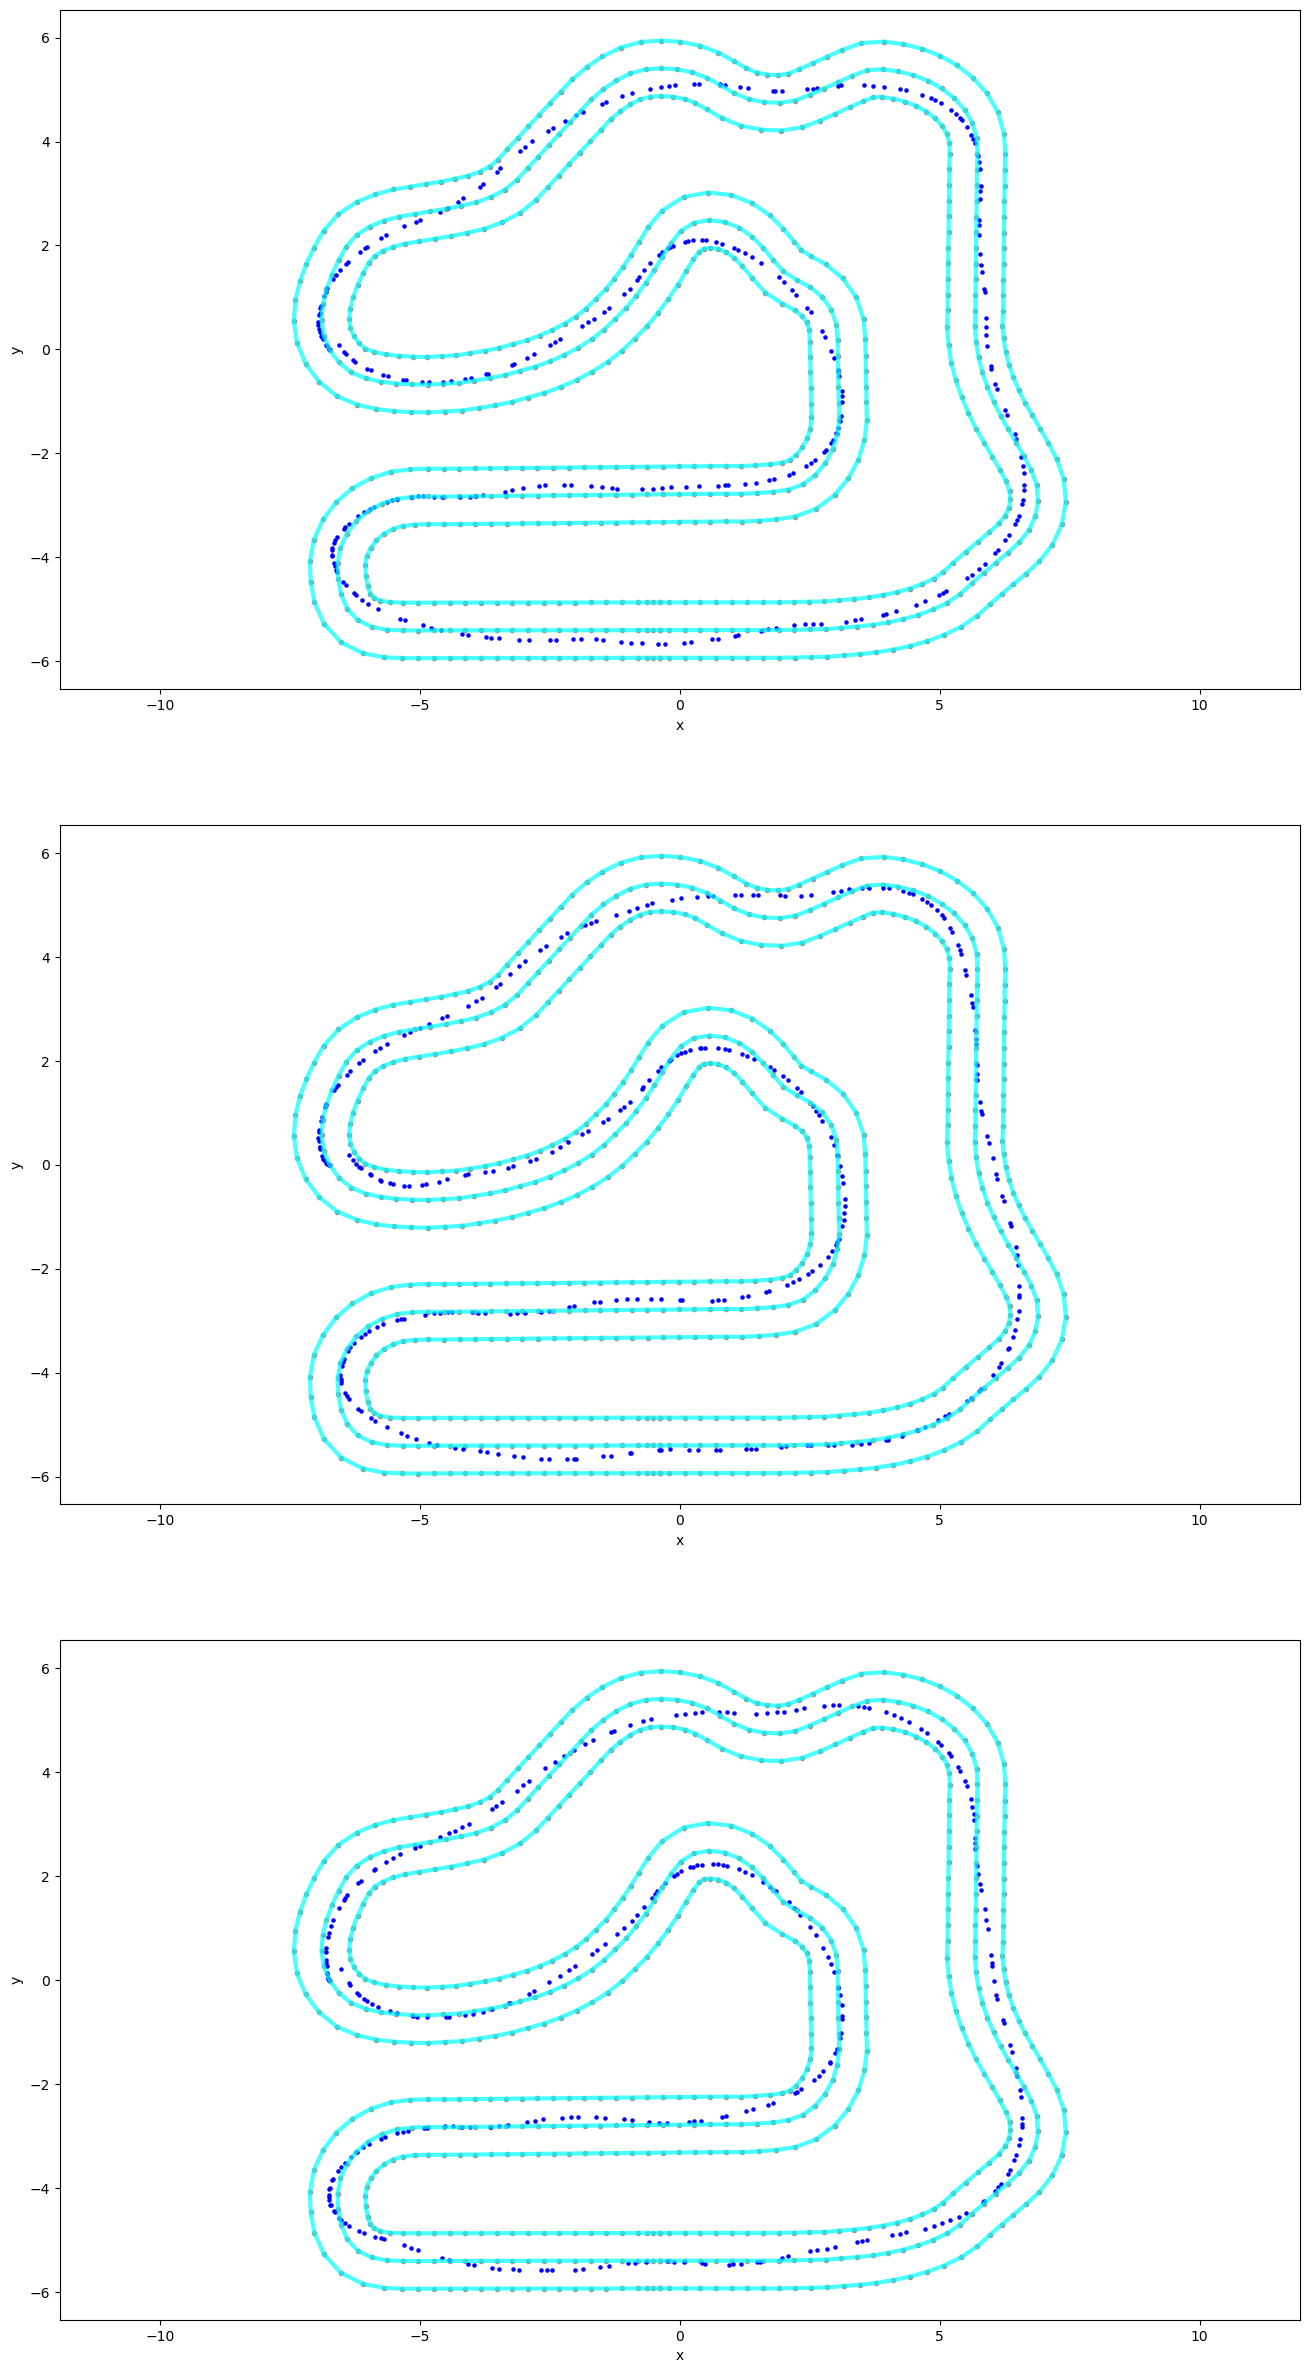

<Figure size 640x480 with 0 Axes>

In [28]:
# Some examples:
# highest reward for complete laps:
episodes_to_plot = complete_ones.nlargest(3,'reward')

# highest progress from all episodes:
# episodes_to_plot = simulation_agg.nlargest(3,'progress')

try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps(episodes_to_plot, df, track, section_to_plot="unique_episode")
    else:
        pu.plot_selected_laps(episodes_to_plot, df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps(episodes_to_plot, df, track)

### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

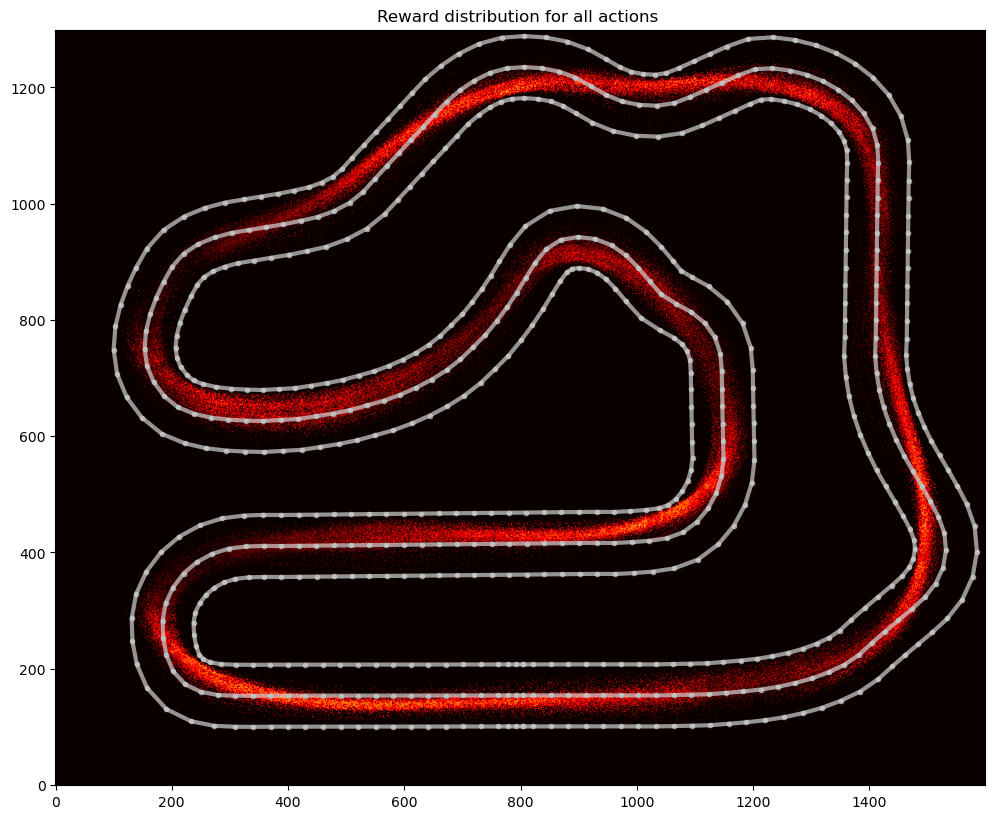

<Figure size 640x480 with 0 Axes>

In [29]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

pu.plot_track(df, track)

### Plot a heatmap of speeds
Plotting speeds for the last 3 episodes

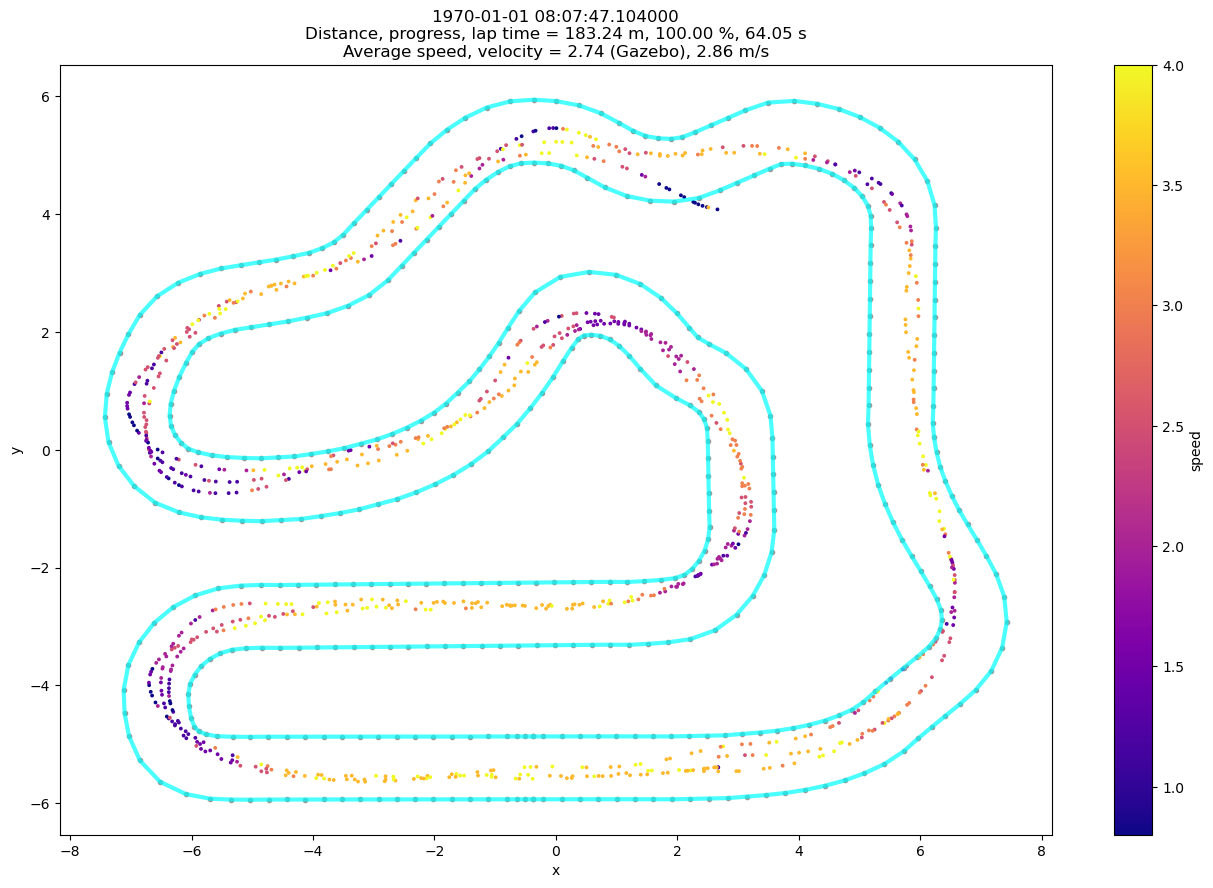

<Figure size 640x480 with 0 Axes>

In [30]:
latest_episode = df['episode'].max()
pu.plot_grid_world(df[df['episode'] > latest_episode - 3], track)

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

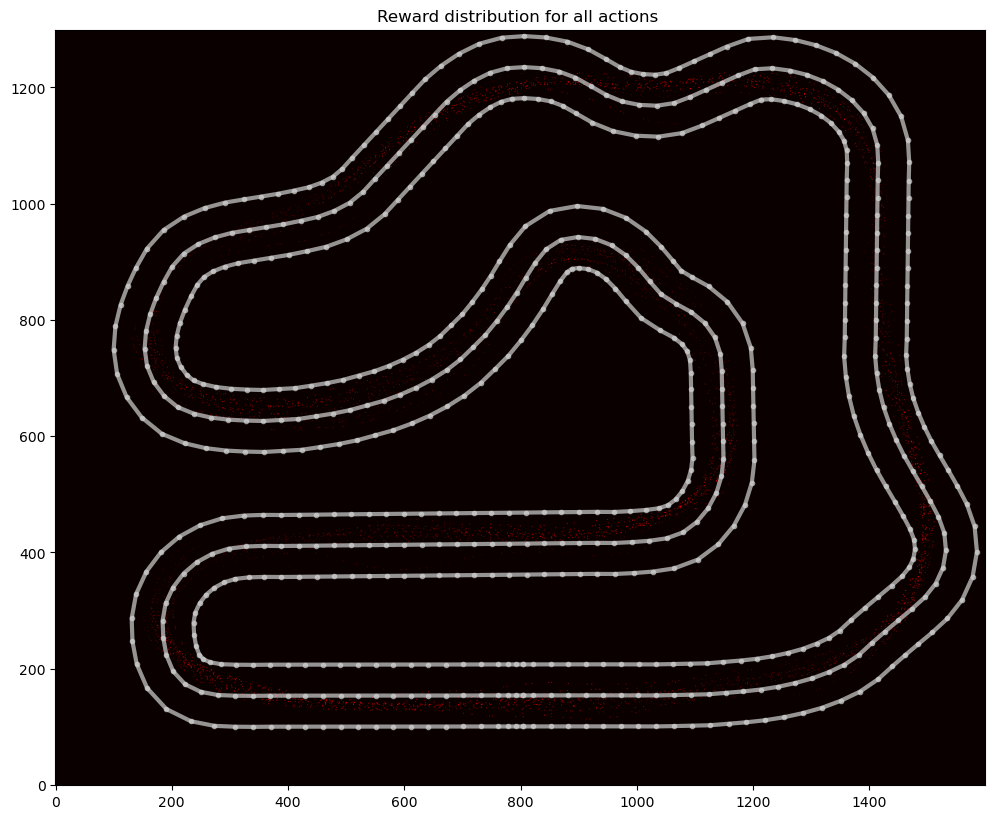

<Figure size 640x480 with 0 Axes>

In [31]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 3

pu.plot_track(df[df['iteration'] == iteration_id], track)

### Path taken in a particular episode

In [32]:
episode_id = 12

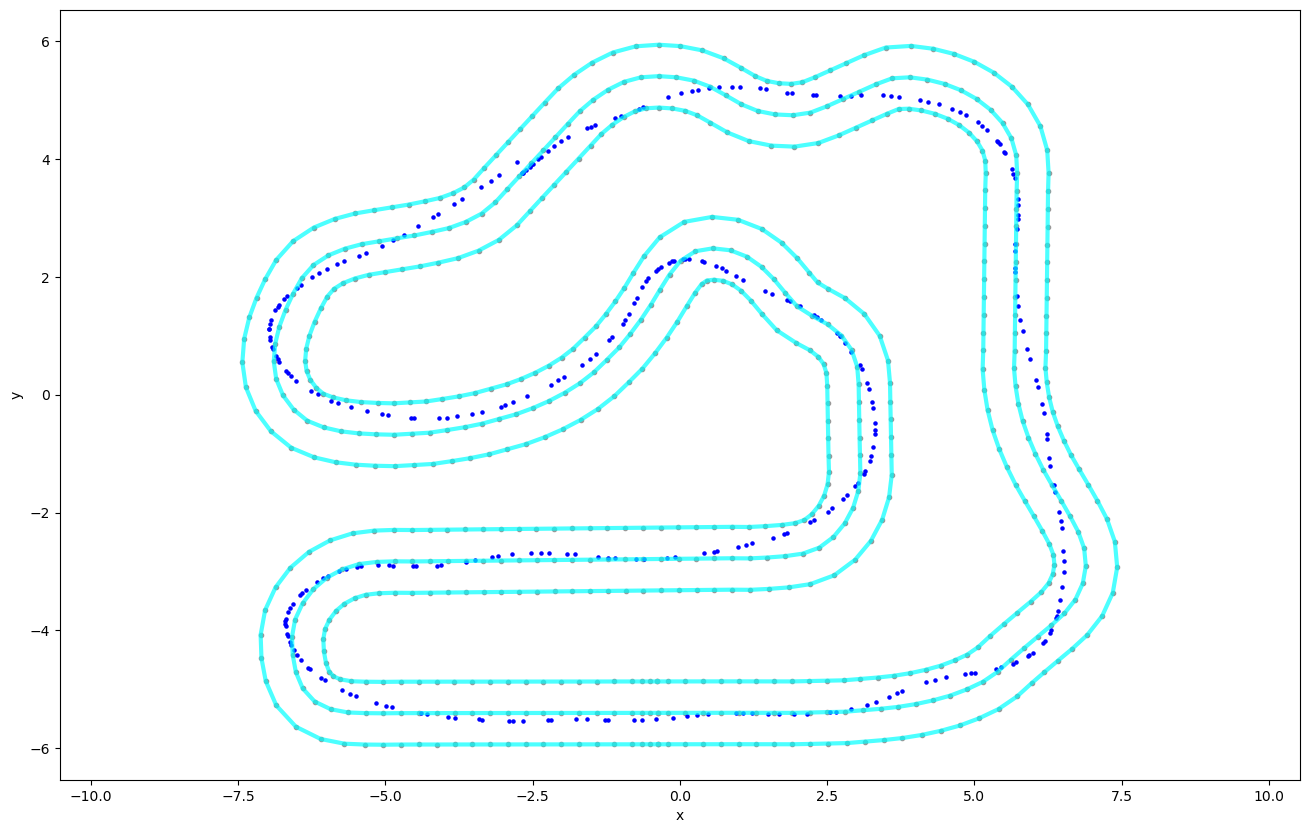

<Figure size 640x480 with 0 Axes>

In [33]:
try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps([episode_id], df, track, section_to_plot="unique_episode")
    else: 
        pu.plot_selected_laps([episode_id], df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps([episode_id], df, track)

### Path taken in a particular iteration

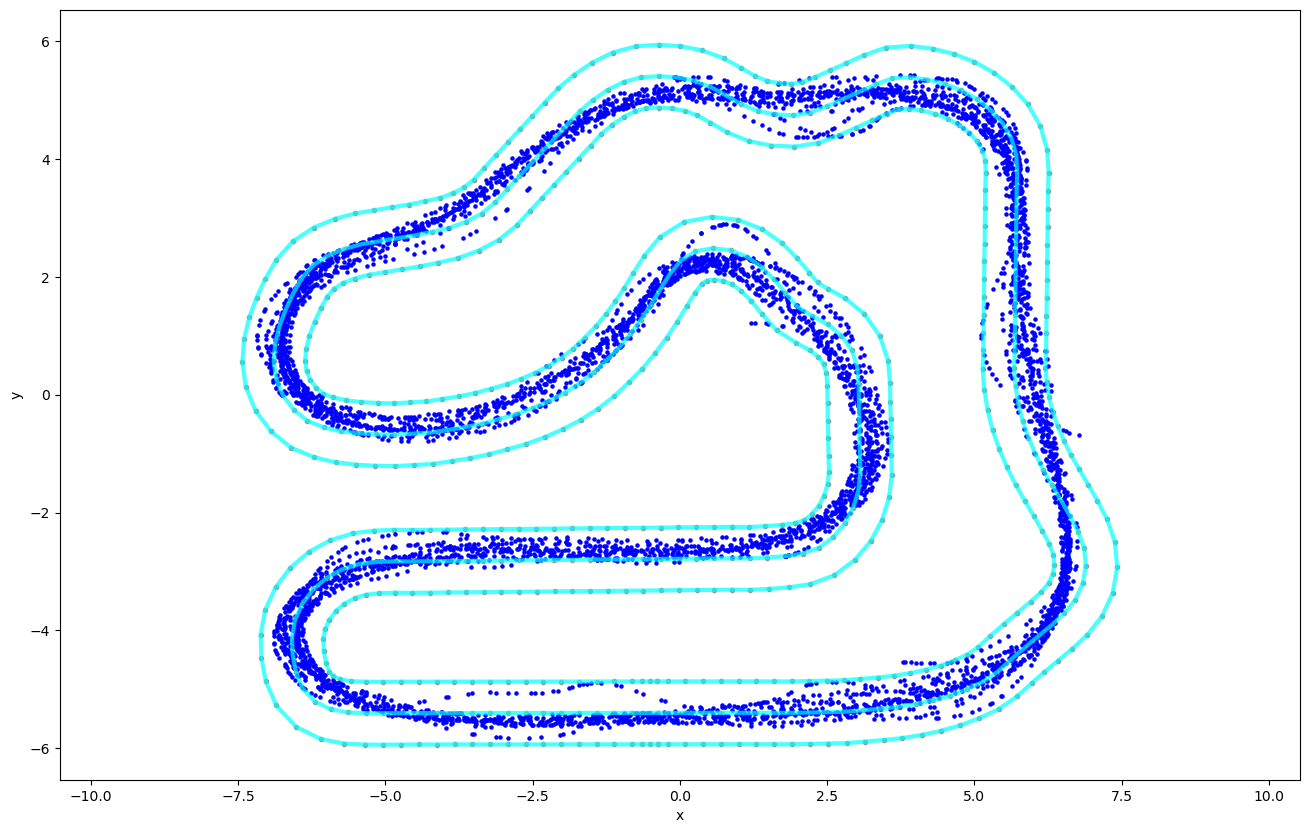

<Figure size 640x480 with 0 Axes>

In [34]:
iteration_id = 10

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

### Check Progress Reward aka Effective Speed
The term effective speed has been devised which is computed
based on the progress percentage and the track length. The effective
speed is the speed that it would have been expected to travel at to have
progressed that far around the track.

It is computed as

progress_percent * track_length / 100 * frame_rate / num_steps

Choosing some interval, say 20 steps you can use the progress it
has made over the last 20 steps to compute an effective speed
over the last 20 steps.

**Note** - Progress can sometimes be negative

In [35]:
np_progress = df['progress'].to_numpy()
np_episode = df['episode'].to_numpy()
track_length = df['track_len'][0]

is_same_episode = np_episode[20:] == np_episode[:-20]
# np.unique(is_same_episode, return_counts=True)

progress_diff = np.where(
    is_same_episode,
    np_progress[20:] - np_progress[:-20],
    np.nan
)
effective_speed = np.full_like(np_progress, np.nan)
effective_speed[20:] = progress_diff * track_length / 100 * 15 / 20
np.unique(np.isnan(progress_diff), return_counts=True), np.unique(np.isnan(effective_speed), return_counts=True)

((array([False,  True]), array([288199,  19980])),
 (array([False,  True]), array([288199,  20000])))

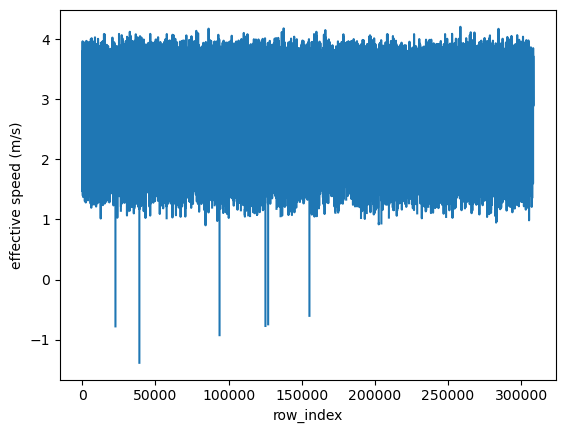

In [36]:
plt.plot(effective_speed)
plt.xlabel('row_index')
plt.ylabel('effective speed (m/s)')
plt.show()

### Cleaning Results
Progress (effective speed) can sometimes be negative so ignore those.

In [37]:
df2 = df.copy()
df2['effective_speed'] = effective_speed
df3 = df2[df2['effective_speed'] > 0.5]
df3

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,delta_time,delta_dist,new_reward,effective_speed
20,0,21.0,-3.194547,-5.421845,171.439548,8.0,3.5,83,0.000008,False,True,4.409813,11,63.858625,9.246,in_progress,0.0,0,0,0,0.015,0.050060,0.000008,2.006784
21,0,22.0,-3.301288,-5.406350,171.421672,8.0,3.5,83,0.000008,False,True,4.576943,11,63.858625,9.350,in_progress,0.0,0,0,0,0.104,0.107860,0.000008,2.086992
22,0,23.0,-3.748574,-5.370085,175.737458,6.0,4.0,76,0.045734,False,True,5.277305,13,63.858625,9.400,in_progress,0.0,0,0,0,0.050,0.448754,0.045734,2.404227
23,0,24.0,-3.875337,-5.367942,177.295227,-6.0,3.5,27,0.073359,False,True,5.475844,13,63.858625,9.479,in_progress,0.0,0,0,0,0.079,0.126781,0.073359,2.491439
24,0,25.0,-4.141169,-5.362468,178.393285,-6.0,3.5,27,0.397134,False,True,5.892202,14,63.858625,9.508,in_progress,0.0,0,0,0,0.029,0.265888,0.397134,2.647874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308194,999,337.0,3.463339,-5.184095,178.404592,6.0,4.0,76,2.436776,False,True,98.955536,201,63.858625,29330.896,in_progress,0.0,49,0,999,0.048,0.410039,2.436776,3.004780
308195,999,338.0,3.241127,-5.185276,175.876055,8.0,3.0,82,3.177833,False,True,99.308640,202,63.858625,29330.932,in_progress,0.0,49,0,999,0.036,0.222215,3.177833,3.123833
308196,999,339.0,3.115119,-5.185221,175.295596,10.0,2.5,89,2.462500,False,True,99.505303,202,63.858625,29331.010,in_progress,0.0,49,0,999,0.078,0.126008,2.462500,2.986333
308197,999,340.0,2.820225,-5.199844,179.381511,8.0,3.5,83,2.483796,False,True,99.967269,203,63.858625,29331.058,in_progress,0.0,49,0,999,0.048,0.295256,2.483796,3.120127


In [38]:
most_rewarded_episodes = df3.groupby(by='episode')['reward'].sum().sort_values(ascending=False).index[:40]
df4 = df3[df3['episode'].isin(most_rewarded_episodes)]
df4

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,delta_time,delta_dist,new_reward,effective_speed
9272,30,21.0,-5.916416,2.068329,38.414913,-4.0,4.0,36,0.662447,False,True,4.252875,117,63.858625,802.982,in_progress,0.0,1,0,30,0.067,0.268894,0.662447,1.932113
9273,30,22.0,-5.829565,2.142395,35.785152,-4.0,4.0,36,0.984384,False,True,4.507382,117,63.858625,803.040,in_progress,0.0,1,0,30,0.058,0.114144,0.984384,2.054106
9274,30,23.0,-5.693394,2.247398,32.094495,-2.0,3.5,43,1.396247,False,True,4.766923,118,63.858625,803.106,in_progress,0.0,1,0,30,0.066,0.171955,1.396247,2.167187
9275,30,24.0,-5.497760,2.381382,27.799118,-2.0,3.0,42,2.530979,False,True,5.160119,119,63.858625,803.155,in_progress,0.0,1,0,30,0.049,0.237116,2.530979,2.342544
9276,30,25.0,-5.376847,2.457220,25.595085,-2.0,3.0,42,2.818146,False,True,5.373654,119,63.858625,803.236,in_progress,0.0,1,0,30,0.081,0.142728,2.818146,2.398888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291695,943,328.0,-5.225850,-2.491366,4.178515,-8.0,3.5,19,0.000008,False,True,99.292340,32,63.858625,27887.054,in_progress,0.0,47,0,943,0.063,0.080561,0.000008,1.224301
291696,943,329.0,-5.095148,-2.501583,0.023847,4.0,4.0,68,0.000008,False,True,99.447779,32,63.858625,27887.135,in_progress,0.0,47,0,943,0.081,0.131101,0.000008,1.271414
291697,943,330.0,-4.911765,-2.514530,-2.375120,4.0,4.0,68,0.000008,False,True,99.734126,33,63.858625,27887.170,in_progress,0.0,47,0,943,0.035,0.183840,0.000008,1.311687
291698,943,331.0,-4.822278,-2.514891,-1.622432,0.0,3.5,51,0.000008,False,True,99.854673,33,63.858625,27887.282,in_progress,0.0,47,0,943,0.112,0.089487,0.000008,1.317868


### Progress (Effective Speed) at Waypoints

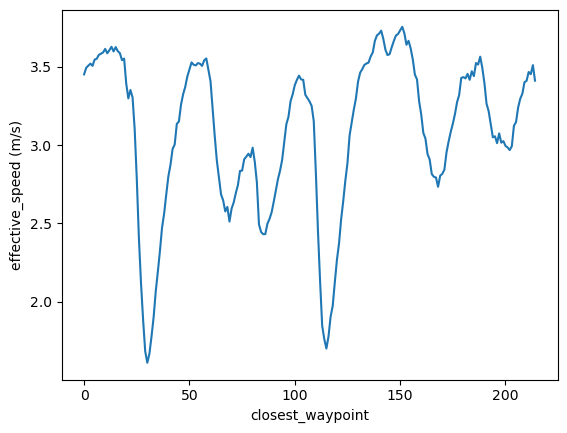

In [39]:
waypoint_efs = df4.groupby('closest_waypoint')['effective_speed'].mean()
waypoint_efs.plot(ylabel='effective_speed (m/s)')
plt.show()

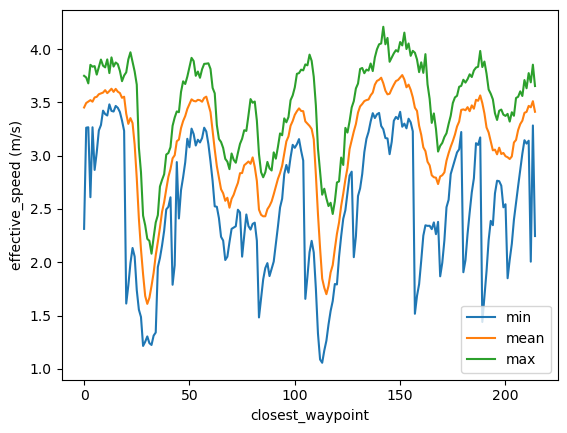

In [40]:
waypoints_efs_mmm = df4.groupby('closest_waypoint')['effective_speed'].agg(['min', 'mean', 'max'])
waypoints_efs_mmm.plot(ylabel='effective_speed (m/s)')
plt.show()

### Export as JSON for Reward Functions

In [41]:
print(waypoints_efs_mmm['max'].to_json())

{"0":3.7490466569,"1":3.7335901936,"2":3.6781662981,"3":3.8521618352,"4":3.8347578554,"5":3.8400074823,"6":3.7604289395,"7":3.8316720017,"8":3.901593236,"9":3.8437511894,"10":3.8283641315,"11":3.9030739977,"12":3.7748141892,"13":3.9220088599,"14":3.8359634966,"15":3.8741326903,"16":3.8583986758,"17":3.7948130622,"18":3.6988199842,"19":3.7520161362,"20":3.7819464193,"21":3.9032630715,"22":3.969799989,"23":3.8779932501,"24":3.7898589937,"25":3.6661196706,"26":3.0775256449,"27":2.8450885043,"28":2.4375316286,"29":2.3473020156,"30":2.2197956513,"31":2.2002724382,"32":2.0807435697,"33":2.232619357,"34":2.3736810872,"35":2.4419607321,"36":2.7105386023,"37":2.7725549751,"38":2.825905556,"39":3.0105498071,"40":3.0247729225,"41":3.0795190673,"42":3.2799763951,"43":3.3579898558,"44":3.415212651,"45":3.4076032215,"46":3.5976615561,"47":3.6975413333,"48":3.6722558372,"49":3.7418984805,"50":3.8317537489,"51":3.917497054,"52":3.8875363664,"53":3.7492495565,"54":3.7891198624,"55":3.7306374287,"56":3.

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [42]:
track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

You can replace episode_ids with iteration_ids and make a breakdown for a whole iteration.

**Note: does not work for continuous action space (yet).** 

In [43]:
# abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[12])